# 선박 입출항데이터의 다변량 상관관계 분석

### --- 분석 배경 및 목적 ---

수출의존도가 높은 우리나라는 전염병이나 전쟁, 유가 등의 외적인 요인으로 경제성장에 쉽게 타격을 받을 수 있다. 
하지만 데이터분석을 통해 미래를 통계적으로 예측해본다면 위험관리와 불확실성 제거에 도움이 될 수 있을 것이다.

많은 데이터들 중에서 선박입출항데이터는 우리나라의 글로벌 경제 영향력과 규모를 거시적으로 가늠해 볼 수 있는 특성을 지녔다.
또한 선박의 교통밀도 분석에 활용 가능하여 원할한 통항로를 선주들에게 제공할 수 있고 안전사고 감소에도 이바지 할 수 있다.

이에 미국금리, 유가, 환율 등 각종 경제지표를 입력 파라미터로 간주하여 선박 입출항과 선형관계를 갖는 주요 요인은 무엇이 있는지 파악해보는 것을 목표로 한다.
분석된 주요요인들을 바탕으로 예측모델링을 수행하고 예측치를 구하는 것을 향후 작업의 방향을 결정할 것이다. 

# 1. 데이터셋 읽기

### (1) 필요한 모듈 설치 
##### - 주석을 풀고 한 번만 실행하면 됩니다!

In [97]:
# !pip install seaborn 
# !pip install matplotlib 
# !pip install pandas
# !pip install openpyxl
# !pip install scipy

### (2) 선박입출항 데이터셋 읽기

In [98]:
import pandas as pd

# 데이터출처: 포트미스
df = pd.read_excel('./data/ship_20231012.xlsx', skiprows=[0,1,2])

# 컬럼명 변경
df.columns = ['조회년도', '조회월', '총계_척수', '총계_톤수', 
              '입항_계_척수', '입항_계_톤수', '입항_외항_척수', '입항_외항_톤수', '입항_내항_척수', '입항_내항_톤수', 
              '출항_계_척수', '출항_계_톤수', '출항_외항_척수', '출항_외항_톤수', '출항_내항_척수', '출항_내항_톤수']

df = df.ffill() # 빈값 채우기
df = df[df['조회월']!='소계'] # data가 '소계'인 경우는 모두 제외

# 조회년도에서 '년'과 '월'없애기
df['period'] = df['조회년도'].str.replace("년",'') + df['조회월'].str.replace('월','')

# 기간, 입항, 출항 데이터만 남기기
df = df[['period', '입항_계_척수', '출항_계_척수']]

df.columns = ['period', 'arr', 'dep'] # 컬럼명 변경
df['period'] = pd.to_numeric(df['period']) # 기간을 숫자로 인식하도록 설정
df_ship = df[df["period"] > 202107] # 2021년 7월 이후 데이터만 추출

# 기간을 인덱스로 설정
df_ship.set_index(df_ship['period'], inplace=True)

print(df_ship)

        period   arr   dep
period                    
202108  202108  1298  1290
202109  202109  1226  1233
202110  202110  1345  1334
202111  202111  1274  1257
202112  202112  1292  1315
202201  202201  1248  1234
202202  202202  1058  1065
202203  202203  1396  1397
202204  202204  1293  1304
202205  202205  1377  1380
202206  202206  1246  1228
202207  202207  1351  1348
202208  202208  1207  1229
202209  202209  1242  1235
202210  202210  1148  1151
202211  202211  1153  1149
202212  202212  1127  1123
202301  202301  1045  1036
202302  202302  1043  1050
202303  202303  1166  1176
202304  202304  1119  1108
202305  202305  1215  1218
202306  202306  1174  1196
202307  202307  1207  1207
202308  202308  1152  1154


c:\Users\winmev\anaconda3\envs\pytest\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


### (3) 미국 기준 금리 데이터셋 읽기


In [99]:
import numpy as np

# 데이터출처: 미연방준비제도이사회
df = pd.read_csv('./data/FRB_PRATES.csv', skiprows=5)
df.columns = ['period', 'RESBME', 'ESBMS', 'RESBM']

# 기간 데이터의 '-'없애기
df["period"] = df['period'].astype(str).str.replace('-', '')
df["period"] = df['period'].astype(int)  # 기간을 숫자로 인식하도록 설정

# 기간을 날짜로 인식하도록 설정
df['period'] = pd.to_datetime(df['period'], format='%Y%m%d') 

# 기간을 인덱스로 설정
df.set_index(df['period'], inplace=True)

# 일별 데이터롸 월별 데이터로 변환
df = df.resample('M').mean()

df["period"] = df.index #인덱스인 날짜 값을 '기간'열에 대입
df["period"] = df['period'].astype(str).str.replace('-', '') # 기간에서 짝대기 제거
df["period"] = df['period'].astype(str).str[:6] # 날짜의 일단위 없애기
df['period'] = pd.to_numeric(df['period']) # 기간을 숫자로 인식하도록 설정

df = df[df["period"] > 202107] # 2021년 7월 이후 데이터만 추출
df_us_ir = df[df["period"] < 202309] # 2023년 9월 미만 데이터만 추출

df_us_ir.set_index(df_us_ir['period'], inplace=True)
df_us_ir = df_us_ir[['RESBM']] # 기준금리 데이터만 추출
print(df_us_ir)

           RESBM
period          
202108  0.150000
202109  0.150000
202110  0.150000
202111  0.150000
202112  0.150000
202201  0.150000
202202  0.150000
202203  0.270968
202204  0.400000
202205  0.835484
202206  1.275000
202207  1.746774
202208  2.400000
202209  2.625000
202210  3.150000
202211  3.850000
202212  4.174194
202301  4.400000
202302  4.641071
202303  4.722581
202304  4.900000
202305  5.125806
202306  5.150000
202307  5.190323
202308  5.400000


### (4) 선박용 유가 데이터셋 읽기

In [100]:
# 데이터출처: OPINET
df = pd.read_csv('./data/정유사_월간판매가격_회사별.csv',encoding='EUC-KR')

df.columns = [ 'period', 'SK', 'GS', 'HD', 'S-OIL', 'SK_gas', 'E1']
df['period'] = df['period'].str.replace("년",'').str.replace('월','') # 년월 글자 제거

df['period'] = pd.to_numeric(df['period']) # 값을 숫자 타입으로 변경
df.set_index(df['period'], inplace=True) # 기간을 인덱스로 설정

df_oil = df[['S-OIL']].copy() # 유가만 추출

print(df_oil)

          S-OIL
period         
202108  1259.56
202109  1243.91
202110  1277.35
202111  1322.33
202112  1271.38
202201  1205.77
202202  1307.98
202203  1420.42
202204  1708.15
202205  1710.20
202206  1805.02
202207  1965.34
202208  1789.66
202209  1675.45
202210  1709.07
202211  1737.87
202212  1675.38
202301  1434.37
202302  1417.71
202303  1367.45
202304  1353.78
202305  1322.65
202306  1238.51
202307  1238.85
202308  1291.70


### (5) 원/달러 환율 데이터셋 읽기

In [101]:
# 데이터출처: e-나라지표
df = pd.read_excel('./data/환율.xlsx', skiprows=[0,1], header=None).T
df.columns = ['period', 'cur_rate','diff']
df = df[2:][:] # 엑셀에서 필요한 부분만 추출
df['period'] = df['period'].str.replace("년",'').str.replace('월','') # 년월 제거
df['cur_rate'] = df['cur_rate'].str.replace(",",'') # 쉽표제거
df['period'] = pd.to_numeric(df['period']) # 값을 숫자 타입으로 변경
df['cur_rate'] = pd.to_numeric(df['cur_rate']) # 값을 숫자 타입으로 변경
df.set_index(df['period'], inplace=True) # 기간을 인덱스로 설정

df_curr= df[['cur_rate']].copy() # 환율만 추출

print(df_curr)

        cur_rate
period          
202108    1159.5
202109    1184.0
202110    1168.6
202111    1187.9
202112    1188.8
202201    1205.5
202202    1202.3
202203    1212.1
202204    1255.9
202205    1237.2
202206    1298.4
202207    1299.1
202208    1337.6
202209    1430.2
202210    1424.3
202211    1318.8
202212    1264.5
202301    1231.9
202302    1322.6
202303    1301.9
202304    1337.7
202305    1327.2
202306    1317.7
202307    1274.6
202308    1321.8


### (6) 데이터 합치기

In [102]:
# 읽어온 데이터를 가로로 붙이기
df = pd.concat([df_ship, df_us_ir, df_oil, df_curr], axis=1)
print(df)

        period   arr   dep     RESBM    S-OIL  cur_rate
period                                                 
202108  202108  1298  1290  0.150000  1259.56    1159.5
202109  202109  1226  1233  0.150000  1243.91    1184.0
202110  202110  1345  1334  0.150000  1277.35    1168.6
202111  202111  1274  1257  0.150000  1322.33    1187.9
202112  202112  1292  1315  0.150000  1271.38    1188.8
202201  202201  1248  1234  0.150000  1205.77    1205.5
202202  202202  1058  1065  0.150000  1307.98    1202.3
202203  202203  1396  1397  0.270968  1420.42    1212.1
202204  202204  1293  1304  0.400000  1708.15    1255.9
202205  202205  1377  1380  0.835484  1710.20    1237.2
202206  202206  1246  1228  1.275000  1805.02    1298.4
202207  202207  1351  1348  1.746774  1965.34    1299.1
202208  202208  1207  1229  2.400000  1789.66    1337.6
202209  202209  1242  1235  2.625000  1675.45    1430.2
202210  202210  1148  1151  3.150000  1709.07    1424.3
202211  202211  1153  1149  3.850000  1737.87   

## 2. 데이터셋의 중요 특징을 시각화

### (1) 여러 요인을 산점도에 그려서 상관관계 분석

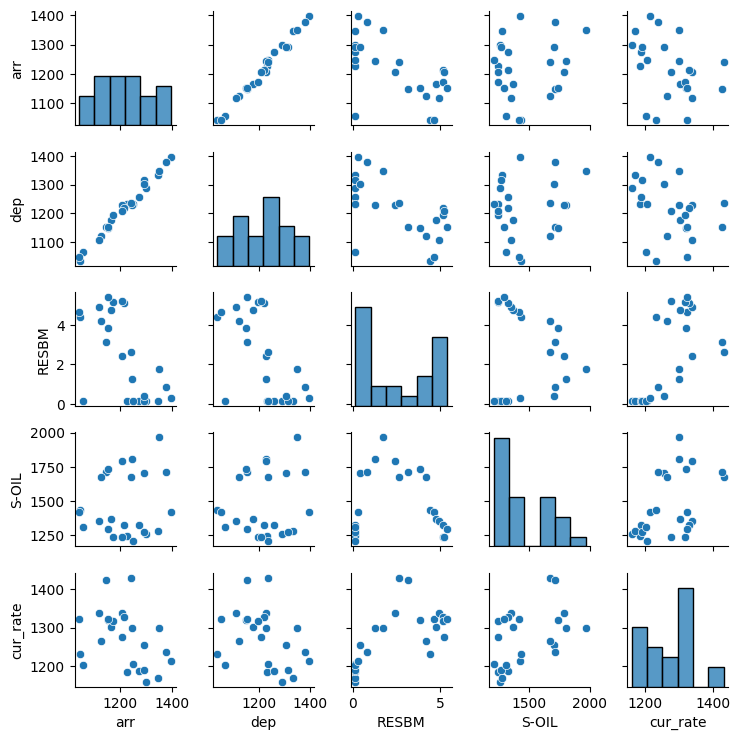

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# 산점도 행렬로 각 특성간의 상관관계를 한 번에 시각화
cols = ['arr', 'dep', 'RESBM', 'S-OIL', 'cur_rate']

# 수치형 데이터를 짝을 지어줌
sns.pairplot(df[cols], height=1.5)
plt.tight_layout()
plt.show()


### (2) 상관계수를 히트맵으로 나타내기

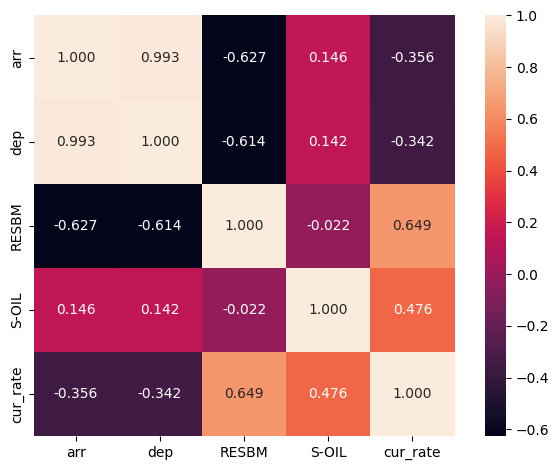

In [104]:
import numpy as np

# 상관계수 구하기
corr = np.corrcoef(df[cols].values.T)

# 상관계수 행렬을 히트맵으로 표현
hm = sns.heatmap(corr,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.3f',
                 annot_kws={'size': 10},
                 yticklabels=cols,
                 xticklabels=cols)

plt.tight_layout()
plt.show()

### (3) 유의 확률로 통계적 검증

In [105]:
import scipy.stats as stats

# 선박의 입항(척수)와 미국기준금리 상관관계 검증
X = df['RESBM'].values
Y = df['arr'].values

# 선박의 입항(척수)와 환율의 상관관계 검증
# X = df['arr'].values
# Y = df['cur_rate'].values

cov = (np.sum(X*Y) - len(X)*np.mean(X)*np.mean(Y)) / len(X)
# cov = np.cov(X, Y) #넘파이를 이용한 공분산
print('공분산', cov)

corr = cov/(np.std(X) * np.std(Y))
print('직접 계산한 상관계수', corr)

r = np.corrcoef(X, Y)
print('넘파이를 이용한 상관계수', r)


# scipy모듈을 이용한 상관계수와 유의확률
# 결론: 유의확률이 0.05미만이면 두 요인간의 상관관계가 통계적으로 유의함
stats.pearsonr(X,Y)


공분산 -125.77917152073641
직접 계산한 상관계수 -0.6273124396813589
넘파이를 이용한 상관계수 [[ 1.         -0.62731244]
 [-0.62731244  1.        ]]


PearsonRResult(statistic=-0.6273124396813634, pvalue=0.0007897944988870981)

### (4) 회귀직선 그리기

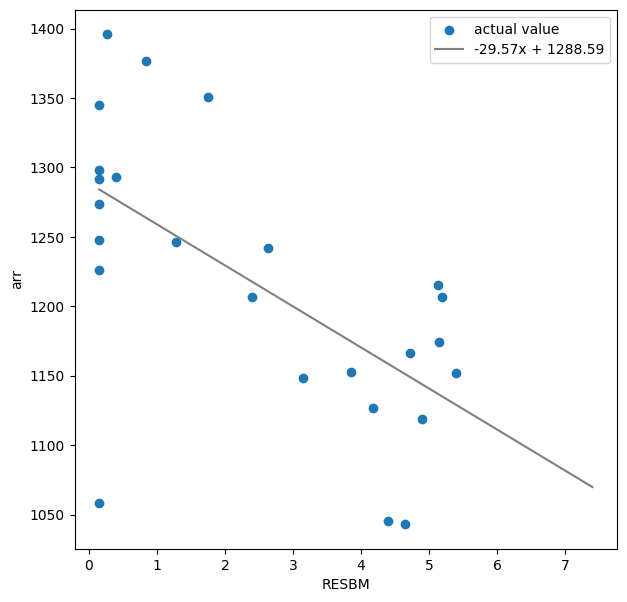

In [159]:
# 기울기와 편차 구하기
poly_fit = np.polyfit(X,Y, 1)
# 회귀직선 함수 구하기
poly_1d = np.poly1d(poly_fit)
# x 좌표 생성
x_vals = np.linspace(X.min(),X.max()+2)
# 회귀직선 함수로 y 좌표 생성
y_vals = poly_1d(x_vals)


fig = plt.figure(figsize=(7,7))
plt.scatter(X,Y, label='actual value')
plt.plot(x_vals, y_vals, color = 'gray', label=f'{poly_fit[0]:.2f}x + {poly_fit[1]:.2f}')
plt.xlabel('RESBM')
plt.ylabel('arr')
plt.legend(loc ='upper right')
plt.show()

In [107]:
# !pip install scikit-learn
# sklearn만 설치
# !pip install -U scikit-learn

### (5) 선형회귀

In [156]:
# 미금리로만 예측하는 모형
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
# x_cols = ['dep', 'RESBM', 'S-OIL', 'cur_rate']
x_cols = ['RESBM']
y_col = ['arr']
# print(df[x_cols])
lin_reg.fit(df[x_cols],df[y_col])
print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict([[5]]))

[1288.58708453] [[-29.56711609]]
[[1140.75150407]]


c:\Users\winmev\anaconda3\envs\pytest\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


[1279.1729678] [[-29.8507738]]
[[1129.91909881]]
62.703928430438204


c:\Users\winmev\anaconda3\envs\pytest\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


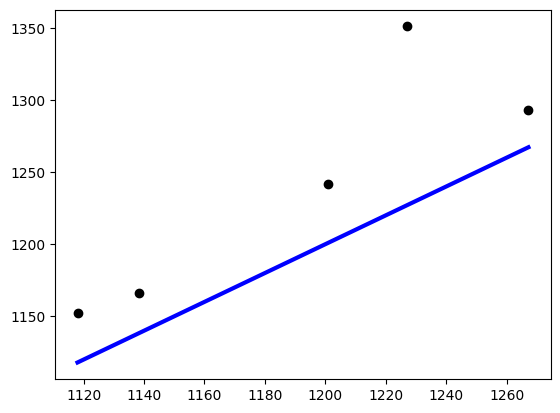

In [157]:
# 학습데이터와 테스트 데이터 분리
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(df[x_cols],df[y_col], test_size=.2)
lin_reg.fit(X_train, y_train)
print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict([[5]]))

y_pred = lin_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

plt.scatter(y_pred, y_test, color = 'black')
x = np.linspace(y_pred.min(), y_pred.max())
plt.plot(x,x, linewidth = 3, color = 'blue')
plt.show()

### (6) 결정 트리 회귀

In [110]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)
# tree_reg.fit(df[x_cols],df[y_col])
y_pred = tree_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

70.7407237735097


### (7) 랜덤포레스트 회귀

In [111]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)
# forest_reg.fit(df[x_cols],df[y_col])
y_pred = forest_reg.predict(X_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

from sklearn.model_selection import cross_val_score
cvs = cross_val_score(forest_reg, y_test, y_pred, scoring="neg_mean_squared_error", cv=5)
rcvs = np.sqrt(-cvs)
print(rcvs.std())



c:\Users\winmev\anaconda3\envs\pytest\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[1242.20107468 1220.2        1343.98816198 1202.19       1198.75      ]
48.588152699167495
39.53928348864442


### (8) 확률적 경사하강법

In [151]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X_train, y_train)
# sgd_reg.fit(df[x_cols],df[y_col])
y_pred = sgd_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

from sklearn.model_selection import cross_val_score
cvs = cross_val_score(forest_reg, y_test, y_pred, scoring="neg_mean_squared_error", cv=5)
rcvs = np.sqrt(-cvs)
print(rcvs.std())


c:\Users\winmev\anaconda3\envs\pytest\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


78.83261436273237
26.96173717338531


### 학습 데이터 크기에 따른 학습곡선

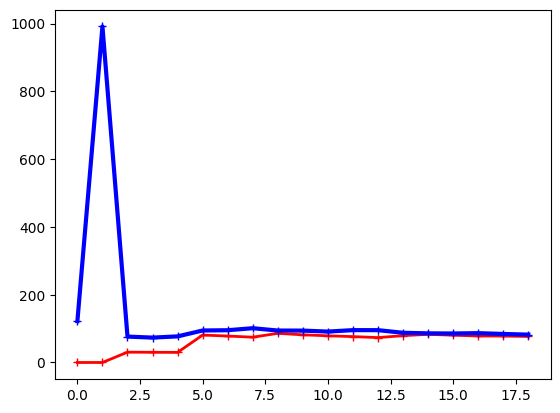

In [155]:
train_errors, val_errors = [], []

model = LinearRegression()

for m in range(1,len(X_train)):
  model.fit(X_train[:m], y_train[:m])
  y_train_predict = model.predict(X_train[:m])
  y_val_predict = model.predict(X_test)
  train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
  val_errors.append(mean_squared_error(y_val_predict, y_test))

plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(val_errors), "b-+", linewidth=3, label="val")
plt.show()

### 다항 회귀와 정규화 

c:\Users\winmev\anaconda3\envs\pytest\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.22972e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\winmev\anaconda3\envs\pytest\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


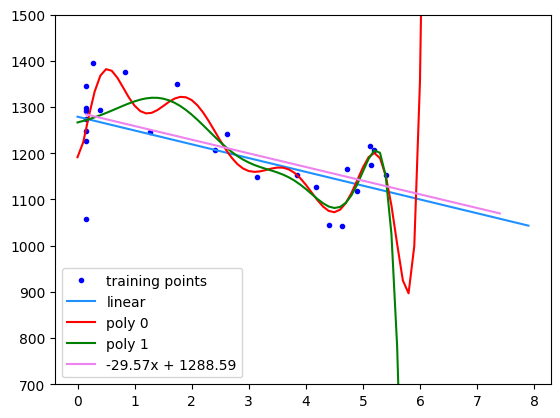

In [184]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# 특성이 하나인 회귀를 다항 회귀로 변환
poly_features = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly_features.fit_transform(df[x_cols])

# 선형 회귀 모델
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# 과대적합 문제를 방지하기 위해 복잡도에 패널티 적용
lin_reg2 = Ridge(alpha=0)
lin_reg2.fit(X_poly,df[y_col])

lin_reg3 = Ridge(alpha=1)
lin_reg3.fit(X_poly,df[y_col])

# 학습 데이터 생성
X_new = np.arange(0, 8, 0.1)[:, np.newaxis]

# 단순 선형 학습
y_predict = lin_reg.predict(X_new)

# 다항 특성 학습
X_poly_new = poly_features.fit_transform(X_new)
y_predict2 = lin_reg2.predict(X_poly_new)
y_predict3 = lin_reg3.predict(X_poly_new)

# 결과 비교 그래프
plt.ylim([700,1500])
plt.plot(df[x_cols],df[y_col], "b.", label='training points')
plt.plot(X_new, y_predict, "dodgerblue", label='linear')
plt.plot(X_new, y_predict2, "r-", label='poly 0')
plt.plot(X_new, y_predict3, "g-", label='poly 1')
plt.plot(x_vals, y_vals, color = 'violet', label=f'{poly_fit[0]:.2f}x + {poly_fit[1]:.2f}')
plt.legend(loc='lower left')
plt.show()